# Spaceship Titanic 

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#データの格納場所の確認
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [5]:
#トレーニングデータとテストデータの取得
# df_train = pd.read_csv('../input/spaceship-titanic/train.csv')
# df_test = pd.read_csv('../input/spaceship-titanic/test.csv')
df_train = pd.read_csv('csv/train.csv')
df_test = pd.read_csv('csv/test.csv')

#トレーニングデータの確認
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
#データの詳細
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [10]:
#欠損値を含む行数
df_train.isnull().any(axis=1).value_counts()

False    6606
True     2087
Name: count, dtype: int64

# 欠損値を含むが多いので特徴量を絞る

In [ ]:
"""
『特徴量の説明』
PassengerId：ユニークなID（gggg_pp）、ggggは旅行グループ、ppはグループ内の番号、グループ内は家族メンバーが多いが、全てではない

HomePlanet；乗客が出発した惑星

CryoSleep；航海中に休眠状態に入ったかどうか、キャビンに閉じ込められている

Cabin；客室番号、deck/num/sideの形式でsideはPortのP(航空機の右側)またはStarboard(航空機の右側)のSのいずれか

Destination：行き先惑星（３カ所ある）

Age；年齢

VIP - 乗客が航海中の特別なVIPサービスに対して追加料金を支払ったかどうか。

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck -数々の高級アメニティで乗客が請求した金額。

Name：乗客の名前と名字


『その他の情報』
train.csv : 2/3のデータ

"""

In [ ]:
"""
『特徴量の優先度』

「大」
PassengerId : ggggの部分 -> ggggに分けて新たな特徴量にしないと・・・
CryoSleep：キャビンにいるか否かで分別できるかも
Cabin：客室の場所を示しているので語尾のsとpでラベルコーディングすればいいかも
VIP：安全性、場所が決まっていると思うので、良い特徴量になるはず

「中」
Age；可能性はあるかも
RoomService, FoodCourt, ShoppingMall, Spa, VRDeck ：いつ、どのくらい利用してたか分からないので何とも言えないが、どれかを利用してたかが良い特徴になるかも？
Name：セカンドネームで家族か分かるかも
　　　　Passengerldの効果が大きかったら、Nameを入れるのもいいかも


「小」
HomePlanet；永住惑星で別次元に飛ばされるとは考えにくい
Destination：行き先惑星関係なくランダムに飛ばされている。

"""

/tmp/ipykernel_232/2280273295.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  planet_rate.append(rate[0].round(2))


'\n全て約50%の割合で飛ばされているので、\n行き先に関係なくランダム飛ばされていることが分かる。\n\n'

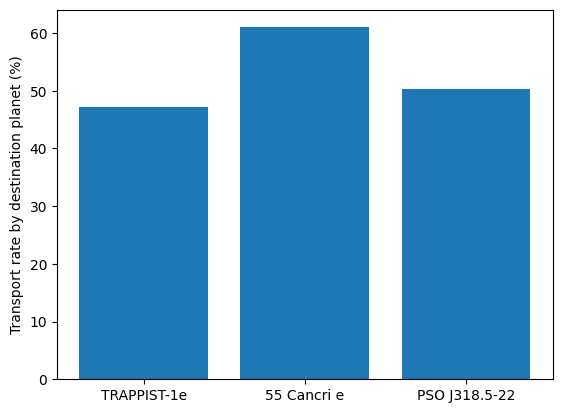

In [11]:
"""
行き先惑星の2番目の途中で飛ばされた可能性があるかもしれない
行き先惑星ごとの総人数で各飛ばされた割合を見る。
"""

#到着惑星における飛ばされた割合(%)
all_num = len(df_train.index)
dest_trans = df_train[['Destination', 'Transported']]

# ーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーー
#↓行き先惑星ごとの飛ばされ率を総乗客で割った場合
# trains_rate = (dest_trans.groupby('Destination').sum() / all_num) * 100
# trains_rate['Transported'] = trains_rate['Transported'].round(1)
# trains_rate
# ーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーー

#各行き先惑星ごとの総人数
dest_count = dest_trans['Destination'].value_counts()

#各行き先惑星ごとの飛ばされた割合
dest_trans_sum = (dest_trans.groupby('Destination').sum())*100

#リスト変換
planet_rate = []
for planet in dest_count.index:
    rate = dest_trans_sum.loc[planet]/dest_count[planet]
    planet_rate.append(rate[0].round(2))

#棒グラフ
plt.bar(dest_count.index, planet_rate)
plt.ylabel('Transport rate by destination planet (%)')

"""
全て約50%の割合で飛ばされているので、
行き先に関係なくランダム飛ばされていることが分かる。

"""

/tmp/ipykernel_232/4160743348.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  home_rate.append(rate[0].round(2))


'\n可能性は限りなくないが、念の為確認\n\u3000HomePlanetに関係なくランダムに飛ばされている。\n\n'

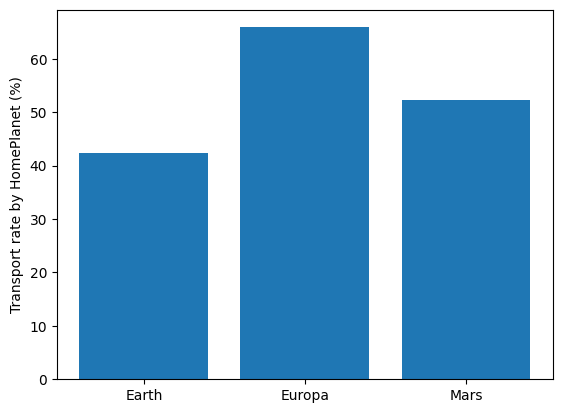

In [12]:
#乗客惑星ごとの総人数ーーーー関数で書けばよかった・・・・
home_df = df_train[['HomePlanet', 'Transported']]
home_count = home_df['HomePlanet'].value_counts()

#各行き先惑星ごとの飛ばされた割合
home_trans_sum = (home_df.groupby('HomePlanet').sum())*100

#リスト変換
home_rate = []
for planet in home_count.index:
    rate = home_trans_sum.loc[planet]/home_count[planet]
    home_rate.append(rate[0].round(2))

#棒グラフ
plt.bar(home_count.index, home_rate)
plt.ylabel('Transport rate by HomePlanet (%)')

"""
可能性は限りなくないが、念の為確認
　HomePlanetに関係なくランダムに飛ばされている。

"""

In [13]:
print(planet_rate)
print(home_rate)

[47.12, 61.0, 50.38]
[42.39, 65.88, 52.3]


In [ ]:
"""
今後の予定

1. 優先度：大の特徴rで特徴量を作成
2. 欠損値確認
3. 欠損値drop()、もし欠損値がかなり多ければ考える
4. 「機械学習のパラメータチューニングを「これでもか！」というくらい丁寧に解説」を参考にパラメータチューニング
   使用モデル：余裕があればlightGBM, 厳しければサイト通りSVM

5. 提出
"""